In [1]:
import pickle
from pathlib import Path
import sys
sys.path.append("../..")
import matplotlib.pyplot as plt
import torch
from neuralhydrology.evaluation import metrics
from neuralhydrology.nh_run import start_run, eval_run

In [ ]:
from neuralhydrology.datasetzoo import hysets

hysets_dir = Path(r"C:\Users\everett\Documents\GitHub\canada_lsh\data\HYSETS\.HYSETS")
basins = hysets.load_hysets_attributes(data_dir=hysets_dir, metadata=True)
basins = basins.loc[basins["Source"] == "HYDAT",:].index.to_list()

In [3]:
from neuralhydrology.modelzoo import Config
import numpy as np
import pandas as pd
from tqdm import tqdm


cfg = Config(Path("hysets_basins.yml"))

availability_file = Path() / "data_availability2.csv"

if availability_file.exists():
    avail = pd.read_csv(availability_file, index_col=0)
else:
    prts = ['train','validation','test']
    avail = pd.DataFrame(index=basins, columns=prts)

    for basin in tqdm(basins):
        df = hysets.load_hysets_timeseries(data_dir=hysets_dir, basin=basin)
        for prt in prts:
            tr = slice(getattr(cfg,f'{prt}_start_date'),getattr(cfg,f'{prt}_end_date'))
            n = len(pd.date_range(start=tr.start, end=tr.stop, freq='D'))
            avail.loc[basin, prt] = 1 - df.loc[tr,:].resample("YE").mean().isnull().any(axis=1).mean()

    avail.to_csv(availability_file)

In [4]:
basins = avail.index[np.all(avail > 0.99, axis=1)].to_list()

def list_to_txt(x:list, filename:Path, open_arg="w+"):
    
    output_file = open(filename, open_arg)
    for item in x:
        output_file.write(item + '\n')

basins = basins
list_to_txt(basins, f"{len(basins)}-hysets-basins.txt")

In [5]:
list_to_txt(hysets.load_hysets_attributes(data_dir=hysets_dir, augmented=False).columns.tolist(),hysets_dir.parent / "static_attributes.txt")

In [6]:
# by default we assume that you have at least one CUDA-capable NVIDIA GPU
start_run(config_file=Path("hysets_basins.yml"))


2025-01-14 11:43:47,682: Logging to c:\Users\everett\Documents\GitHub\neuralhydrology\examples\07-Canada\runs\nse_ar_1401_114347\output.log initialized.
2025-01-14 11:43:47,683: ### Folder structure created at c:\Users\everett\Documents\GitHub\neuralhydrology\examples\07-Canada\runs\nse_ar_1401_114347
2025-01-14 11:43:47,684: ### Run configurations for nse_ar
2025-01-14 11:43:47,684: experiment_name: nse_ar
2025-01-14 11:43:47,685: train_basin_file: 445-hysets-basins.txt
2025-01-14 11:43:47,686: validation_basin_file: 445-hysets-basins.txt
2025-01-14 11:43:47,687: test_basin_file: 445-hysets-basins.txt
2025-01-14 11:43:47,688: train_start_date: 1982-10-01 00:00:00
2025-01-14 11:43:47,689: train_end_date: 1994-09-30 00:00:00
2025-01-14 11:43:47,690: validation_start_date: 1994-10-01 00:00:00
2025-01-14 11:43:47,690: validation_end_date: 2006-09-30 00:00:00
2025-01-14 11:43:47,691: test_start_date: 2006-10-01 00:00:00
2025-01-14 11:43:47,691: test_end_date: 2018-09-30 00:00:00
2025-01-14

2025-01-14 11:43:47,693: validate_every: 1
2025-01-14 11:43:47,693: validate_n_random_basins: 12
2025-01-14 11:43:47,694: metrics: ['NSE', 'KGE', 'PI']
2025-01-14 11:43:47,694: model: arlstm
2025-01-14 11:43:47,695: head: regression
2025-01-14 11:43:47,695: output_activation: linear
2025-01-14 11:43:47,696: hidden_size: 256
2025-01-14 11:43:47,696: initial_forget_bias: 3
2025-01-14 11:43:47,697: output_dropout: 0.4
2025-01-14 11:43:47,698: optimizer: Adam
2025-01-14 11:43:47,698: loss: NSE
2025-01-14 11:43:47,699: learning_rate: {0: 0.001, 10: 0.0005, 20: 0.0001}
2025-01-14 11:43:47,699: batch_size: 256
2025-01-14 11:43:47,700: epochs: 50
2025-01-14 11:43:47,700: clip_gradient_norm: 1
2025-01-14 11:43:47,701: predict_last_n: 1
2025-01-14 11:43:47,701: seq_length: 365
2025-01-14 11:43:47,703: num_workers: 8
2025-01-14 11:43:47,703: log_interval: 5
2025-01-14 11:43:47,704: log_tensorboard: True
2025-01-14 11:43:47,704: log_n_figures: 1
2025-01-14 11:43:47,705: save_weights_every: 1
2025-

KeyboardInterrupt: 

### Evaluate run on test set
The run directory that needs to be specified for evaluation is printed in the output log above. Since the folder name is created dynamically (including the date and time of the start of the run) you will need to change the `run_dir` argument according to your local directory name. By default, it will use the same device as during the training process.

In [6]:
run_dir = Path("runs/nse_ar_1811_054939")
eval_run(run_dir=run_dir, period="test", epoch=30)

c:\Users\everett\Documents\GitHub\neuralhydrology\examples\07-Canada\../..\neuralhydrology\evaluation\tester.py:133: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  self.model

# Evaluation: 100%|██████████| 445/445 [1:01:06<00:00,  8.24s/it]


### Load and inspect model predictions
Next, we load the results file and compare the model predictions with observations. The results file is always a pickled dictionary with one key per basin (even for a single basin). The next-lower dictionary level is the temporal resolution of the predictions. In this case, we trained a model only on daily data ('1D'). Within the temporal resolution, the next-lower dictionary level are `xr`(an xarray Dataset that contains observations and predictions), as well as one key for each metric that was specified in the config file.

In [ ]:
run_dir = Path("runs/nse_ar_1811_054939")

with open(run_dir / "test" / "model_epoch030" / "test_results.p", "rb") as fp:
    results = pickle.load(fp)
    
results.keys()

dict_keys(['01AD003', '01AF007', '01AJ003', '01AJ004', '01AJ010', '01AK001', '01AK006', '01AK007', '01AL002', '01AL004', '01AM001', '01AN002', '01AP002', '01AP004', '01AQ001', '01BC001', '01BE001', '01BJ003', '01BJ007', '01BJ010', '01BL002', '01BL003', '01BO001', '01BP001', '01BQ001', '01BS001', '01BU002', '01BV006', '01CA003', '01DG003', '01DL001', '01DP004', '01DR001', '01EC001', '01ED007', '01EE005', '01EF001', '01EJ001', '01EO001', '01FA001', '01FB001', '01FB003', '01FJ002', '02AB008', '02AB017', '02AC001', '02AC002', '02AD010', '02BA003', '02BB003', '02BF001', '02BF002', '02BF004', '02CA002', '02CB003', '02CD006', '02CF007', '02CF008', '02CF012', '02DD013', '02DD014', '02DD015', '02EA005', '02EA010', '02EB014', '02EC002', '02EC009', '02ED003', '02ED007', '02FA002', '02FB007', '02FB010', '02FE009', '02FF004', '02FF007', '02FF008', '02GA010', '02GA018', '02GC002', '02GC018', '02GD004', '02GD021', '02GE005', '02GG002', '02GG006', '02GG009', '02GH003', '02HA006', '02HB004', '02HB012',

results.keys()[0]

The data variables in the xarray Dataset are named according to the name of the target variables, with suffix `_obs` for the observations and suffix `_sim` for the simulations.

In [13]:
list(results.keys())[0]

'01AD003'

Let's plot the model predictions vs. the observations

<xarray.DataArray 'q(mm/d)_obs' (date: 4383, time_step: 1)>
array([[       nan],
       [0.6258011 ],
       [0.6220536 ],
       ...,
       [0.0861882 ],
       [0.11616671],
       [0.16862905]], dtype=float32)
Coordinates:
  * date       (date) datetime64[ns] 1982-10-01 1982-10-02 ... 1994-09-30
  * time_step  (time_step) int64 0

Text(0.5, 1.0, 'Test period - NSE 0.931')

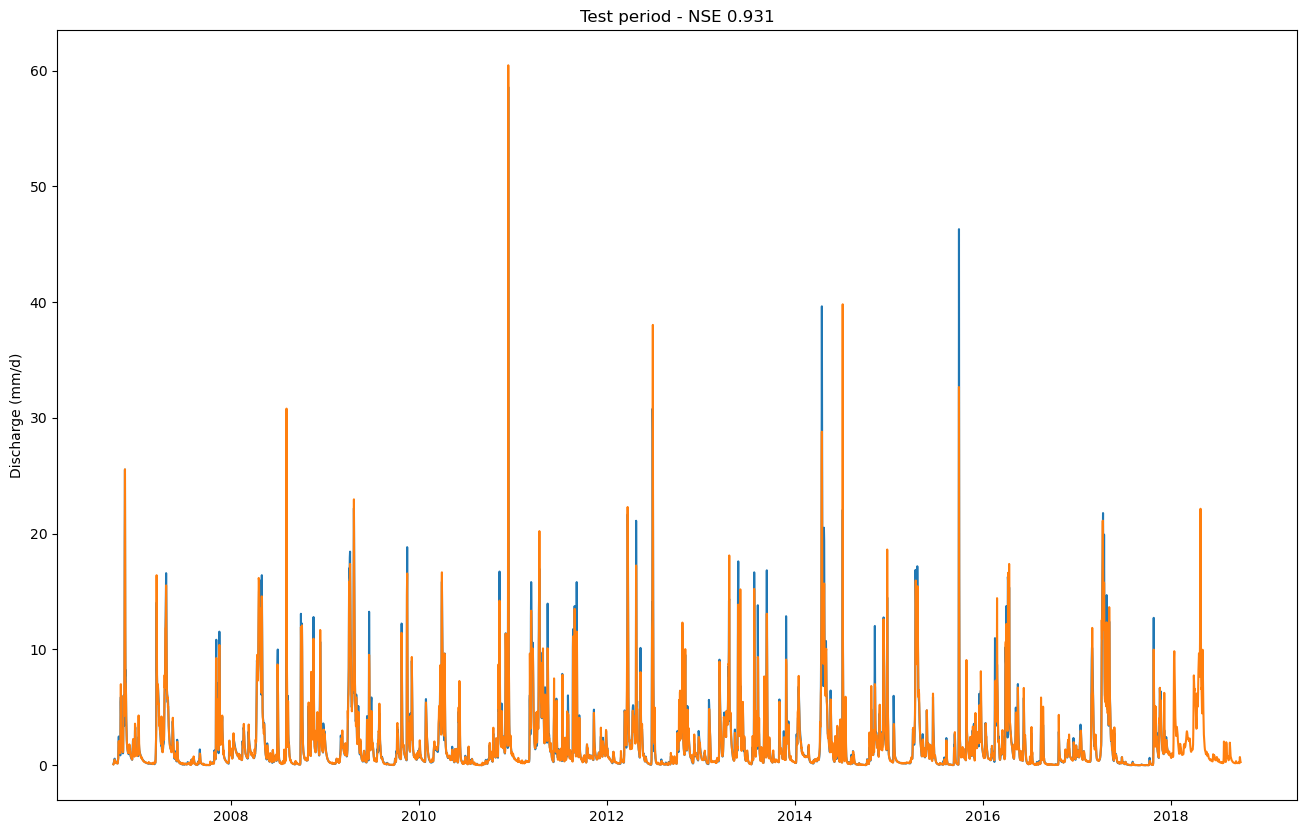

In [23]:
# extract observations and simulations
qobs = results['01AK007']['1D']['xr']['q(mm/d)_obs']
qsim = results['01AK007']['1D']['xr']['q(mm/d)_sim']

fig, ax = plt.subplots(figsize=(16,10))
ax.plot(qobs['date'], qobs)
ax.plot(qsim['date'], qsim)
ax.set_ylabel("Discharge (mm/d)")
ax.set_title(f"Test period - NSE {results['01AK007']['1D']['NSE']:.3f}")

Next, we are going to compute all metrics that are implemented in the NeuralHydrology package. You will find additional hydrological signatures implemented in `neuralhydrology.evaluation.signatures`.

In [ ]:
values = metrics.calculate_all_metrics(qobs.isel(time_step=-1), qsim.isel(time_step=-1))
for key, val in values.items():
    print(f"{key}: {val:.3f}")

c:\Users\everett\Documents\GitHub\neuralhydrology\examples\01-Introduction\../..\neuralhydrology\datautils\utils.py:339: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  offset_one = to_offset(freq_one)
c:\Users\everett\Documents\GitHub\neuralhydrology\examples\01-Introduction\../..\neuralhydrology\datautils\utils.py:382: FutureWarning: 'H' is deprecated and will be removed in a future version. Please use 'h' instead of 'H'.
  factor = pd.to_timedelta(freq_one) / pd.to_timedelta(freq_two)


NSE: 0.803
MSE: 0.968
RMSE: 0.984
KGE: 0.871
Alpha-NSE: 0.936
Beta-KGE: 1.044
Beta-NSE: 0.040
Pearson-r: 0.898
FHV: -8.186
FMS: -5.655
FLV: -268.469
Peak-Timing: 0.130
Peak-MAPE: 29.906
